<a href="https://colab.research.google.com/github/Aditya3016/SpecTrek-The-Mobile-Recommender-/blob/main/Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Web Scraping**

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

# Lists to store scraped data
Product_Name = []
Prices = []
Description = []
Reviews = []
RAM = []
ROM = []
Battery = []
Brands = []

# Known mobile brands
known_brands = [
    "Samsung", "Redmi", "Realme", "iQOO", "Vivo", "Motorola", "Infinix", "POCO",
    "Lava", "Nokia", "OnePlus", "Nothing", "Apple", "Tecno", "Micromax", "Honor"
]

# Function to extract brand from product name
def extract_brand(name):
    for brand in known_brands:
        if name.lower().startswith(brand.lower()):
            return brand
    return name.split()[0]  # fallback

headers = {"User-Agent": "Mozilla/5.0"}

# 🔄 Scrape from page 2 to 30
for i in range(2, 31):
    url = f"https://www.flipkart.com/search?q=mobiles+under+30k&page={i}"
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, "lxml")
    box = soup.find("div", class_="DOjaWF gdgoEp")

    if box is None:
        print(f"[!] Product container not found on page {i}")
        continue

    names = box.find_all("div", class_="KzDlHZ")
    prices = box.find_all("div", class_="Nx9bqj _4b5DiR")
    descriptions = box.find_all("ul", class_="G4BRas")
    reviews = box.find_all("div", class_="XQDdHH")

    min_length = min(len(names), len(prices), len(descriptions), len(reviews))

    for j in range(min_length):
        name = names[j].text.strip()
        price = prices[j].text.strip()
        desc = descriptions[j].text.strip()
        review = reviews[j].text.strip()

        # Extract RAM, ROM, Battery using regex
        ram_match = re.search(r'(\d{1,2})\s?GB\s?(RAM|Memory)', desc, re.IGNORECASE)
        rom_match = re.search(r'(\d{2,4})\s?GB\s?(ROM|Storage)', desc, re.IGNORECASE)
        battery_match = re.search(r'(\d{4,5})\s?mAh', desc, re.IGNORECASE)

        RAM.append(ram_match.group(1) + " GB" if ram_match else None)
        ROM.append(rom_match.group(1) + " GB" if rom_match else None)
        Battery.append(battery_match.group(1) + " mAh" if battery_match else None)

        # Clean description
        cleaned_desc = re.sub(r'(\d+\s?GB\s?(RAM|Memory))', '', desc, flags=re.IGNORECASE)
        cleaned_desc = re.sub(r'(\d+\s?GB\s?(ROM|Storage))', '', cleaned_desc, flags=re.IGNORECASE)
        cleaned_desc = re.sub(r'(\d{4,5}\s?mAh.*?)(Battery)?', '', cleaned_desc, flags=re.IGNORECASE)
        cleaned_desc = re.sub(r'\s{2,}', ' ', cleaned_desc).strip()

        # Append all data
        Product_Name.append(name)
        Prices.append(price)
        Description.append(cleaned_desc)
        Reviews.append(review)
        Brands.append(extract_brand(name))

# ✅ Create DataFrame
df = pd.DataFrame({
    "Brand": Brands,
    "Product Name": Product_Name,
    "Prices": Prices,
    "RAM": RAM,
    "ROM": ROM,
    "Battery": Battery,
    "Description": Description,
    "Reviews": Reviews
})

# 🚫 Remove unwanted brands
df = df[~df['Product Name'].str.contains(r'everyday|duracell', flags=re.IGNORECASE, regex=True)]

# 🔁 Remove duplicate product names
df = df.drop_duplicates(subset=['Product Name'])

# ✅ Final Check
print(f"\nTotal Products in Final Data: {len(df)}")

# 💾 Save CSV
df.to_csv(r"C:/Users/gadit/OneDrive/Desktop/FK_under_30k_final.csv", index=False)
print("[✔] Cleaned CSV with Brand column saved successfully.")


# **Loading**

**Dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from scipy.sparse import csr_matrix
from wordcloud import WordCloud
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df=pd.read_csv("/content/FK_under_30k_with_brands.csv")
print(df.shape)

(635, 8)


# **EDA Process**

**EDA**

In [3]:
#Data Cleaning
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  635 non-null    object 
 1   Prices        635 non-null    object 
 2   RAM           635 non-null    object 
 3   ROM           635 non-null    object 
 4   Battery       635 non-null    object 
 5   Description   635 non-null    object 
 6   Reviews       635 non-null    float64
 7   Brand         635 non-null    object 
dtypes: float64(1), object(7)
memory usage: 39.8+ KB
None


In [4]:
#Check for NULL values
print(pd.isnull(df).sum())

Product Name    0
Prices          0
RAM             0
ROM             0
Battery         0
Description     0
Reviews         0
Brand           0
dtype: int64


In [5]:
#Column Names
print(df.columns)

Index(['Product Name', 'Prices', 'RAM', 'ROM', 'Battery', 'Description',
       'Reviews', 'Brand'],
      dtype='object')


In [6]:
#Description
print(df.describe())

          Reviews
count  635.000000
mean     4.300945
std      0.191538
min      3.200000
25%      4.200000
50%      4.300000
75%      4.400000
max      4.800000


*Rating Distribution*

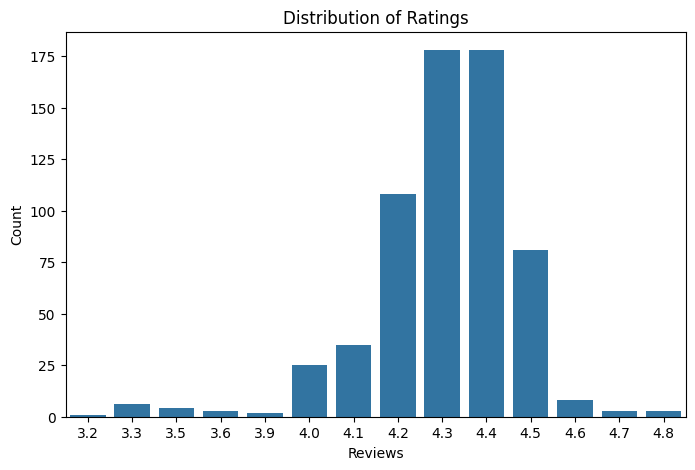

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x='Reviews', data=df)
plt.title("Distribution of Ratings")
plt.xlabel("Reviews")
plt.ylabel("Count")
plt.show()

*Price Distribution Plot*

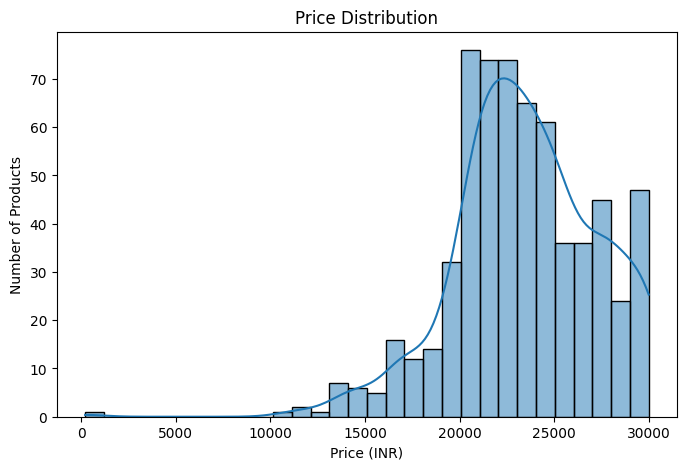

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df['Prices'] = df['Prices'].astype(str).str.replace('₹', '').str.replace(',', '').astype(float)

plt.figure(figsize=(8, 5))
sns.histplot(df['Prices'], bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (INR)")
plt.ylabel("Number of Products")
plt.show()

*Top Brands by Frequency*

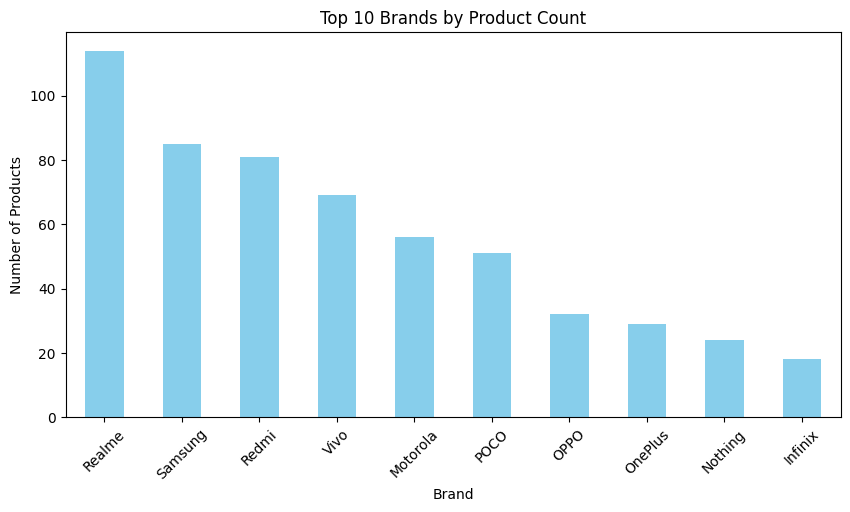

In [9]:
plt.figure(figsize=(10, 5))
df['Brand'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Brands by Product Count")
plt.xlabel("Brand")
plt.ylabel("Number of Products")
plt.xticks(rotation=45)
plt.show()

*RAM Distribution*

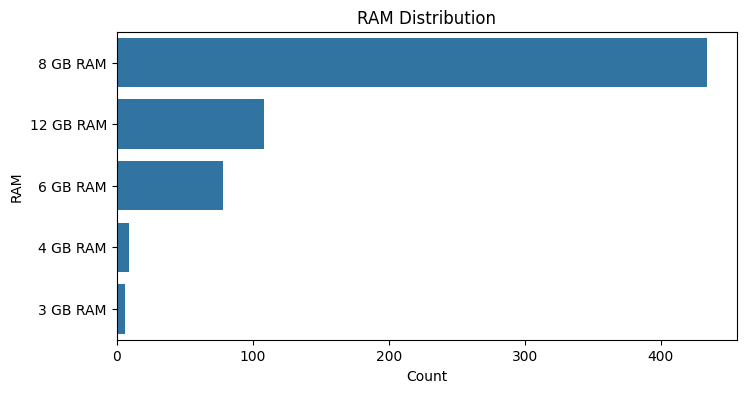

In [10]:
plt.figure(figsize=(8, 4))
sns.countplot(y=df['RAM'].dropna(), order=df['RAM'].value_counts().index)
plt.title("RAM Distribution")
plt.xlabel("Count")
plt.ylabel("RAM")
plt.show()

*Missing Value Heatmap*

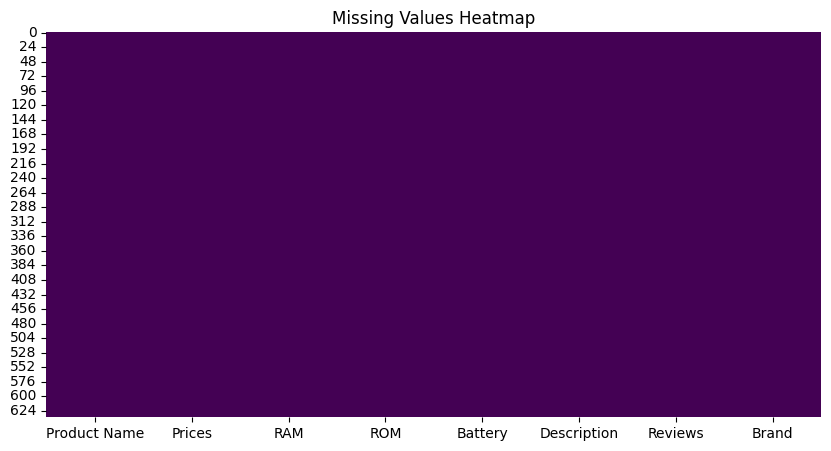

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

*TF-IDF Vectorization on Description*

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Description'].fillna(''))

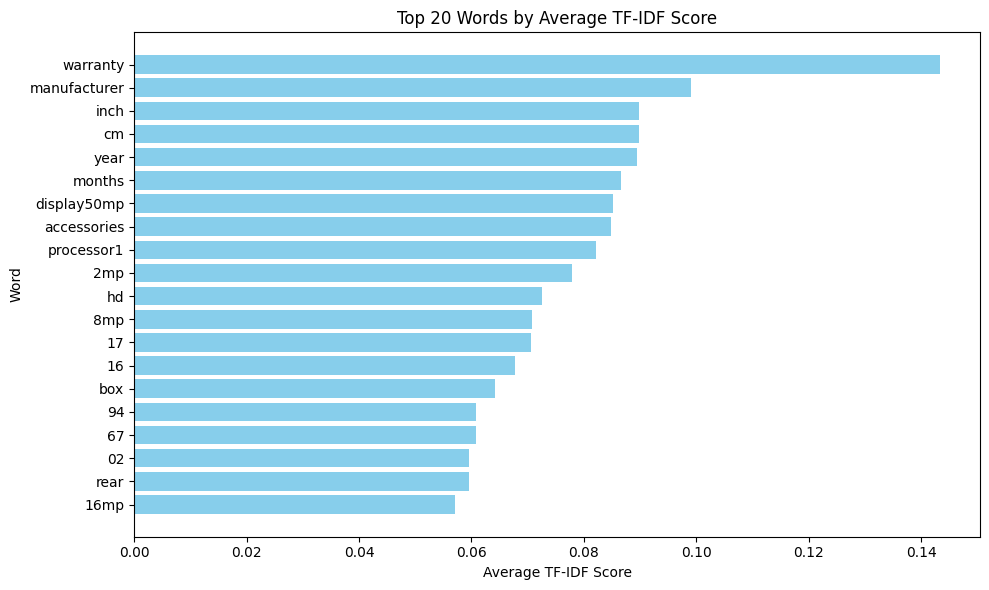

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get feature names and average TF-IDF scores
feature_names = tfidf.get_feature_names_out()
avg_tfidf_scores = tfidf_matrix.mean(axis=0).A1  # Convert sparse matrix to flat array

# Create DataFrame of words and scores
tfidf_df = pd.DataFrame({
    'word': feature_names,
    'avg_score': avg_tfidf_scores
})

# Sort and plot top 20
top_words = tfidf_df.sort_values(by='avg_score', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_words['word'][::-1], top_words['avg_score'][::-1], color='skyblue')
plt.title("Top 20 Words by Average TF-IDF Score")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

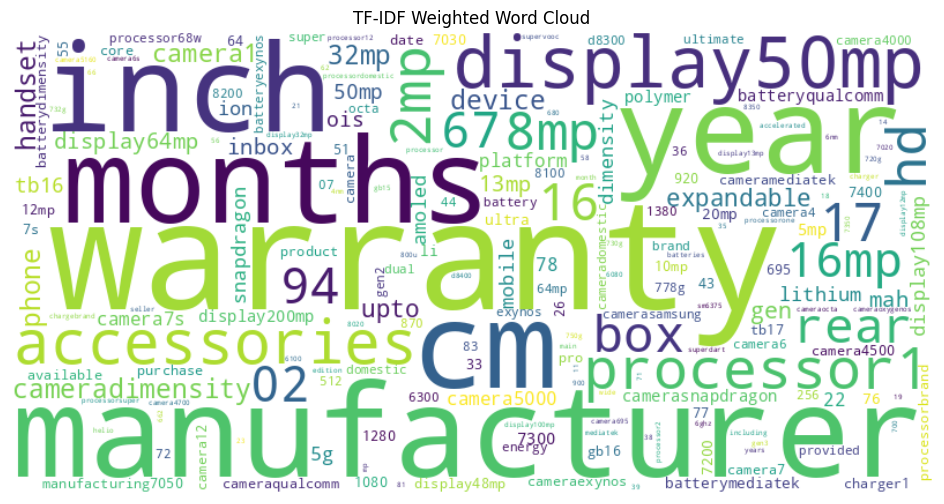

In [14]:
from wordcloud import WordCloud

# Create dictionary of word: avg_score
word_scores = dict(zip(tfidf_df['word'], tfidf_df['avg_score']))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("TF-IDF Weighted Word Cloud")
plt.show()

*Cosine Similarity Matrix*

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

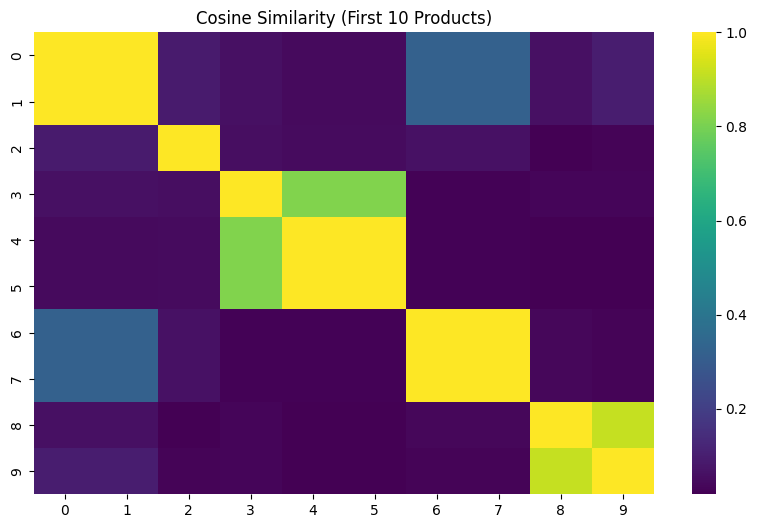

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(cosine_sim[:10, :10], cmap='viridis')
plt.title("Cosine Similarity (First 10 Products)")
plt.show()

# **Plots**

*Reviews Distribution Plot*

<Axes: xlabel='Reviews', ylabel='Count'>

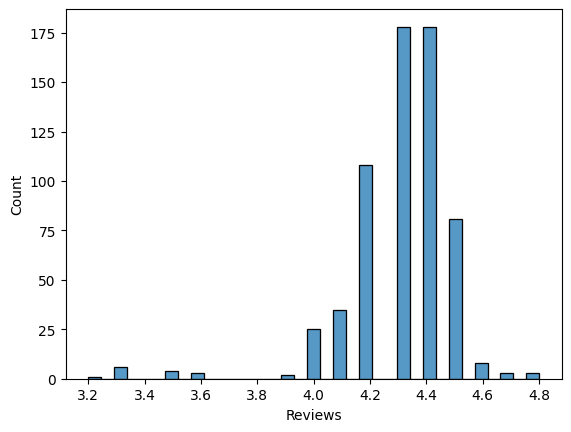

In [17]:
sns.histplot(df['Reviews'])

*Top Brands by Count*

<Axes: xlabel='Brand'>

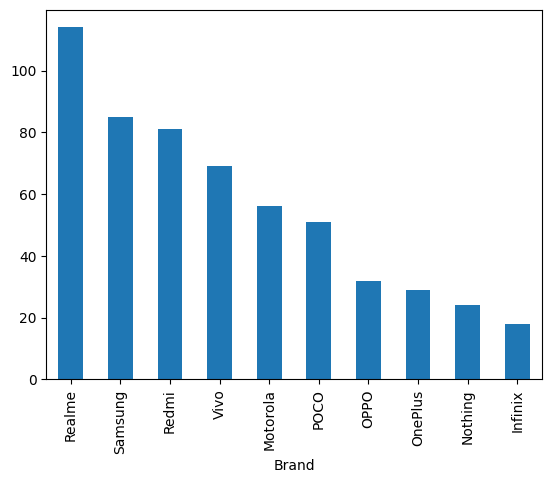

In [18]:
df['Brand'].value_counts().head(10).plot(kind='bar')

*Missing Value Heatmap*

<Axes: >

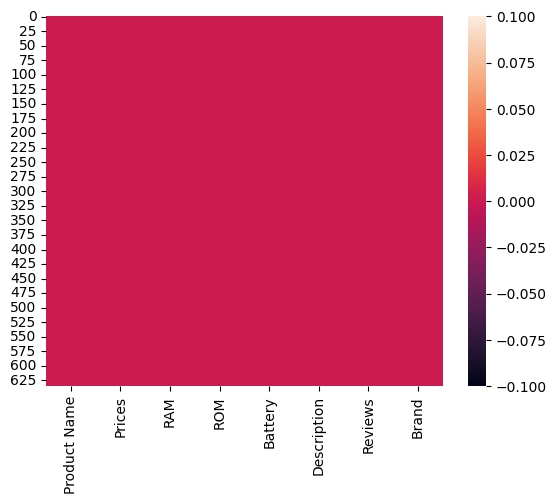

In [19]:
sns.heatmap(df.isnull())

*RAM Distribution*

<Axes: xlabel='count', ylabel='RAM'>

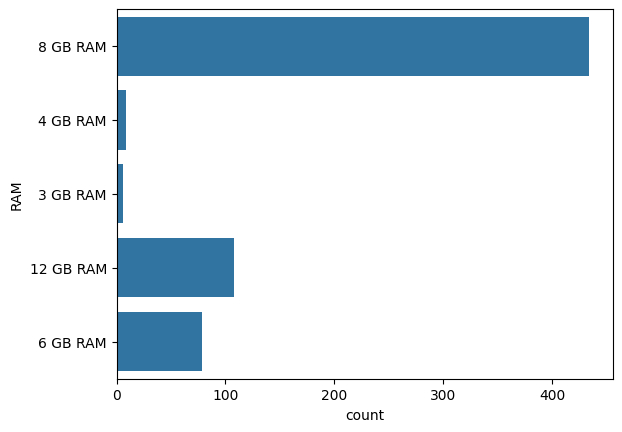

In [20]:
sns.countplot(df['RAM'])

*ROM Distribution*

<Axes: xlabel='count', ylabel='ROM'>

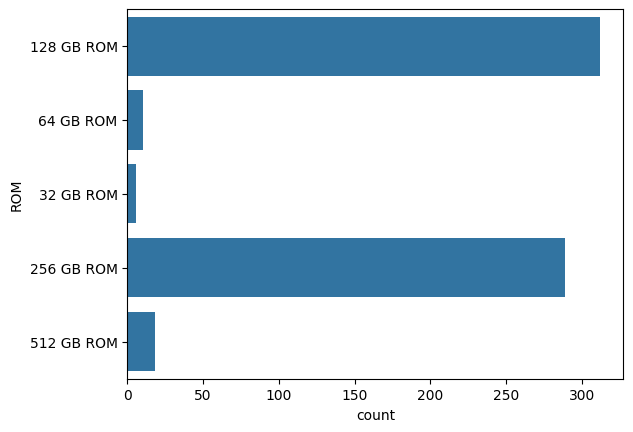

In [21]:
sns.countplot(df['ROM'])

# **Recommendation Function**

In [22]:

indices = pd.Series(df.index, index=df['Product Name']).drop_duplicates()


from difflib import get_close_matches
def get_recommendations(product_name, cosine_sim = cosine_sim):
    matches = get_close_matches(product_name, df['Product Name'], n=1, cutoff=0.5)
    if not matches:
        print(f"[!] No close match found for '{product_name}'")
        return []
    matched_name = matches[0]
    idx = df[df['Product Name'] == matched_name].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    product_indices = [i[0] for i in sim_scores]


    print(f"Showing recommendations for: {matched_name}")
    return df['Product Name'].iloc[product_indices]

*Test the Recommender*

In [23]:
df['Product Name'].head(10).tolist()

['Alcatel V3 Ultra 5G (Hyper Blue, 128 GB)',
 'Alcatel V3 Ultra 5G (Ocean Grey, 128 GB)',
 'ASUS Zenfone 4 Selfie Pro (Red, 64 GB)',
 'BlackBerry Keyone (Silver, 32 GB)',
 'BlackBerry passport (Black, 32 GB)',
 'BlackBerry Passport (Black, 32 GB)',
 'CMF by Nothing Phone 2 Pro (Light Green, 256 GB)',
 'CMF by Nothing Phone 2 Pro (Orange, 256 GB)',
 'Google Pixel 7a (Charcoal, 128 GB)',
 'Google Pixel 7a (Sea, 128 GB)']

In [24]:
get_recommendations("Redmi Note 12")

[!] No close match found for 'Redmi Note 12'


[]

In [25]:
get_recommendations("Samsung Galaxy M14 5G (Smoky Teal, 128 GB)")

Showing recommendations for: Samsung Galaxy A16 5G (Gold, 128 GB)


,Product Name
469,"Samsung Galaxy A16 5G (Light Green, 256 GB)"
188,"OPPO A5 Pro 5G (Feather Blue, 256 GB)"
189,"OPPO A5 Pro 5G (Mocha Brown, 256 GB)"
194,"OPPO F27 5G (Aber Orange, 128 GB)"
203,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...


# **Content-Based Recommendation**

In [27]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack

# Step 1: Load dataset
df = pd.read_csv("/content/FK_cleaned.csv")

# Step 2: Clean numerical columns

# Clean Price
df['Prices'] = df['Prices'].astype(str).str.replace('₹', '', regex=False).str.replace(',', '', regex=False)
df['Prices'] = pd.to_numeric(df['Prices'], errors='coerce')

# Clean Battery
df['Battery'] = df['Battery'].astype(str).str.replace('mAh', '', regex=False).str.replace(',', '', regex=False).str.strip()
df['Battery'] = pd.to_numeric(df['Battery'], errors='coerce')

# Clean Review Score from Reviews
df['Reviews'] = df['Reviews'].astype(str).str.extract(r'(\d+\.?\d*)')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# Drop rows with missing essentials
df = df.dropna(subset=['Product Name', 'Description', 'Prices', 'RAM', 'ROM', 'Battery', 'Reviews'])

# Step 3: TF-IDF Vectorization on Description
tfidf = TfidfVectorizer(stop_words='english', max_features=300)
tfidf_matrix = tfidf.fit_transform(df['Description'].astype(str))

# Step 4: One-Hot Encode RAM & ROM
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ram_rom_encoded = encoder.fit_transform(df[['RAM', 'ROM']].astype(str))

# Step 5: Scale Price, Battery, Review_Score
scaler = MinMaxScaler()
numeric_features = scaler.fit_transform(df[['Prices', 'Reviews', 'Battery']])

# Step 6: Combine All Features
combined_features = hstack([tfidf_matrix, ram_rom_encoded, numeric_features])

# Step 7: Compute Cosine Similarity
cosine_sim = cosine_similarity(combined_features, combined_features)

# ✅ Check alignment
print("Cosine similarity shape:", cosine_sim.shape)
print("DataFrame length:", len(df))

# Step 8: Map product names to indices
product_indices = pd.Series(df.index, index=df['Product Name']).drop_duplicates()

# Step 9: Recommender Function with Category Breakdown
def recommend(product_name, num_recommendations=5):
    if product_name not in product_indices:
        print(f"[!] Product '{product_name}' not found.")
        return []

    idx = product_indices[product_name]
    sim_scores = list(enumerate(cosine_sim[idx].flatten()))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
    indices = [i[0] for i in sim_scores]

    # ✅ Filter out any invalid indices
    valid_indices = [i for i in indices if i < len(df)]

    results = df.iloc[valid_indices].copy()


    # Categorization
    results['Price Category'] = pd.cut(results['Prices'], bins=[0, 12000, 18000, 25000, 35000],
                                       labels=['Budget', 'Mid-Range', 'Upper Mid', 'Premium'])
    results['Battery Level'] = pd.cut(results['Battery'], bins=[0, 4000, 5000, 6000, 7000],
                                      labels=['Low', 'Avg', 'Good', 'Monster'])
    results['RAM Info'] = results['RAM'].astype(str) + " RAM"
    results['ROM Info'] = results['ROM'].astype(str) + " Storage"

    return results[['Product Name', 'Prices', 'Price Category', 'Battery', 'Battery Level',
                    'RAM Info', 'ROM Info', 'Reviews']]

# 🔍 Example Usage
query = "Honor 90 5G (Midnight Black, 512 GB)"
print(f"📱 Recommended for: {query}")
print(recommend(query))

Cosine similarity shape: (563, 563)
DataFrame length: 563
📱 Recommended for: Honor 90 5G (Midnight Black, 512 GB)
                            Product Name  Prices Price Category  Battery  \
17  Honor 90 5G (Midnight Black, 512 GB)   21695      Upper Mid     5000   
18  Honor 90 5G (Midnight Black, 512 GB)   28999        Premium     5000   

   Battery Level       RAM Info            ROM Info  Reviews  
17           Avg  12 GB RAM RAM  512 GB ROM Storage      4.2  
18           Avg  12 GB RAM RAM  512 GB ROM Storage      4.2  


In [28]:
from difflib import get_close_matches

def recommend(product_name, num_recommendations=5):
    # Rebuild index mapping to ensure it's in sync with df
    product_indices = pd.Series(df.index, index=df['Product Name']).drop_duplicates()

    # Fuzzy match the input name to the closest product name
    matches = get_close_matches(product_name, df['Product Name'], n=1, cutoff=0.5)

    if not matches:
        print(f"[!] No close match found for '{product_name}'")
        return []

    matched_name = matches[0]
    idx = df[df['Product Name'] == matched_name].index[0]

    # Compute similarity scores
    sim_scores = list(enumerate(cosine_sim[idx].flatten()))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
    indices = [i[0] for i in sim_scores]
    results = df.iloc[indices].copy()

    # Categorization
    results['Price Category'] = pd.cut(results['Prices'], bins=[0, 12000, 18000, 25000, 35000],
                                       labels=[' Budget', ' Mid-Range', ' Upper Mid', ' Premium'])
    results['Battery Level'] = pd.cut(results['Battery'], bins=[0, 4000, 5000, 6000, 7000],
                                      labels=[' Low', ' Avg', ' Good', ' Monster'])
    results['RAM Info'] = results['RAM'].astype(str) + " RAM"
    results['ROM Info'] = results['ROM'].astype(str) + " Storage"

    # Display results
    print(f"\n Recommendations for: {matched_name}\n")
    return results[['Product Name', 'Prices', 'Price Category', 'Battery', 'Battery Level',
                    'RAM Info', 'ROM Info', 'Reviews']]

recommend("Nothing Phone (3a) Pro")


 Recommendations for: Nothing Phone (3a) Pro (Black, 128 GB)



,Product Name,Prices,Price Category,Battery,Battery Level,RAM Info,ROM Info,Reviews
134,"Nothing Phone (3a) (Black, 128 GB)",24999,Upper Mid,5000,Avg,8 GB RAM RAM,128 GB ROM Storage,4.5
135,"Nothing Phone (3a) (Blue, 128 GB)",24999,Upper Mid,5000,Avg,8 GB RAM RAM,128 GB ROM Storage,4.5
137,"Nothing Phone (3a) (White, 128 GB)",24999,Upper Mid,5000,Avg,8 GB RAM RAM,128 GB ROM Storage,4.5
124,"Nothing Phone (2a) 5G (Blue, 128 GB)",27990,Premium,5000,Avg,8 GB RAM RAM,128 GB ROM Storage,4.4
521,"vivo V30 5G (Classic Black, 128 GB)",27508,Premium,5000,Avg,8 GB RAM RAM,128 GB ROM Storage,4.5


# **Item-Item Collaborative Filtering**

In [29]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("/content/FK_cleaned.csv")

# Extract Review_Score from Reviews
df['Review_Score'] = df['Reviews'].astype(str).str.extract(r'(\d+\.?\d*)', expand=False)
df['Review_Score'] = pd.to_numeric(df['Review_Score'], errors='coerce')

# Drop missing scores/products
df = df.dropna(subset=['Product Name', 'Review_Score'])

# Simulate user_id if not present
if 'user_id' not in df.columns:
    np.random.seed(42)
    df['user_id'] = np.random.randint(1, 101, size=len(df))  # 100 synthetic users

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

# Create item–user matrix
item_user_matrix = df.pivot_table(index='Product Name', columns='user_id', values='Review_Score').fillna(0)

# Compute item–item similarity matrix
item_sim_matrix = cosine_similarity(item_user_matrix)
item_sim_df = pd.DataFrame(item_sim_matrix, index=item_user_matrix.index, columns=item_user_matrix.index)

In [31]:
def item_collab_recommend(product_name, sim_df=item_sim_df, top_n=5):
    product_name = product_name.strip()
    if product_name not in sim_df.index:
        return f"Product '{product_name}' not found."

    similar_items = sim_df[product_name].sort_values(ascending=False)[1:top_n+1]
    return pd.DataFrame({
        'Recommended Product': similar_items.index,
        'Similarity Score': similar_items.values
    })

#Example usage
query = "realme Narzo 60x 5G (Stellar Green, 128 GB)"
print(f"Recommendations for: {query}")
print(item_collab_recommend(query))

Recommendations for: realme Narzo 60x 5G (Stellar Green, 128 GB)
Product 'realme Narzo 60x 5G (Stellar Green, 128 GB)' not found.


In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display  # 👈 For clean table output in notebooks

# STEP 1: Load and Clean Ratings
df = pd.read_csv("/content/FK_cleaned.csv")

# Extract ratings from Reviews column
df['Review_Score'] = df['Reviews'].astype(str).str.extract(r'(\d+\.?\d*)', expand=False)
df['Review_Score'] = pd.to_numeric(df['Review_Score'], errors='coerce')
df = df.dropna(subset=['Product Name', 'Review_Score'])

# Simulate user_id if not present
if 'user_id' not in df.columns:
    np.random.seed(42)
    df['user_id'] = np.random.randint(1, 101, size=len(df))  # 100 synthetic users

# STEP 2: Create Item-User Matrix + Cosine Similarity
item_user_matrix = df.pivot_table(index='Product Name', columns='user_id', values='Review_Score').fillna(0)
item_sim_matrix = cosine_similarity(item_user_matrix)
item_sim_df = pd.DataFrame(item_sim_matrix, index=item_user_matrix.index, columns=item_user_matrix.index)

# STEP 3: Collaborative Recommender with Fallback
def item_collab_recommend(product_name, top_n=5):
    product_name = product_name.strip()

    if product_name not in item_sim_df.index:
        print(f"Product '{product_name}' not found in similarity matrix.")
        print("Showing most highly rated products instead:\n")

        top_rated = (
            df.groupby('Product Name')['Review_Score']
            .mean()
            .sort_values(ascending=False)
            .head(top_n)
            .reset_index()
        )
        return top_rated.rename(columns={'Review_Score': 'Avg Rating'})

    similar_items = item_sim_df[product_name].sort_values(ascending=False)[1:top_n+1]
    results = df[df['Product Name'].isin(similar_items.index)].copy()

    return results[[
        'Product Name', 'Prices', 'Battery', 'RAM', 'ROM', 'Review_Score'
    ]].drop_duplicates().sort_values(by='Review_Score', ascending=False).reset_index(drop=True)

# STEP 4: Try with an Invalid Product Name
invalid_query = "Samsung Galaxy Z99 Ultra"
print(f"\n Trying with product: '{invalid_query}'")
display(item_collab_recommend(invalid_query))  # Display as table

# STEP 5: Try with a Valid Product
valid_query = "realme Narzo 60x 5G (Stellar Green, 128 GB)"
print(f"\n Trying with product: '{valid_query}'")
display(item_collab_recommend(valid_query))  # Display as table


 Trying with product: 'Samsung Galaxy Z99 Ultra'
Product 'Samsung Galaxy Z99 Ultra' not found in similarity matrix.
Showing most highly rated products instead:



,Product Name,Avg Rating
0,"realme Narzo 80 Pro 5G (Speed Silver, 256 GB)",4.8
1,"realme NARZO 80 Pro 5G (Nitro Orange, 256 GB)",4.8
2,"Honor 200 Lite 5G (Midnight Black, 256 GB)",4.7
3,"OnePlus 9 5G (Arctic Sky, 256 GB)",4.7
4,"Honor 200 Lite 5G (Starry Blue, 256 GB)",4.7



 Trying with product: 'realme Narzo 60x 5G (Stellar Green, 128 GB)'
Product 'realme Narzo 60x 5G (Stellar Green, 128 GB)' not found in similarity matrix.
Showing most highly rated products instead:



,Product Name,Avg Rating
0,"realme Narzo 80 Pro 5G (Speed Silver, 256 GB)",4.8
1,"realme NARZO 80 Pro 5G (Nitro Orange, 256 GB)",4.8
2,"Honor 200 Lite 5G (Midnight Black, 256 GB)",4.7
3,"OnePlus 9 5G (Arctic Sky, 256 GB)",4.7
4,"Honor 200 Lite 5G (Starry Blue, 256 GB)",4.7


In [33]:
def item_collab_recommend_enriched(product_name, top_n=5):
    product_name = product_name.strip()

    if product_name not in item_sim_df.index:
        print(f"Product '{product_name}' not found. Showing top-rated products instead.\n")
        fallback_df = (
            df.groupby('Product Name')['Review_Score']
            .mean()
            .sort_values(ascending=False)
            .head(top_n)
            .reset_index()
        )
        return fallback_df.rename(columns={'Review_Score': 'Avg Rating'})

    similar_items = item_sim_df[product_name].sort_values(ascending=False)[1:top_n+1]
    results = df[df['Product Name'].isin(similar_items.index)].copy()

    enriched = results[[
        'Product Name', 'Prices', 'Battery', 'RAM', 'ROM', 'Review_Score'
    ]].drop_duplicates().sort_values(by='Review_Score', ascending=False).reset_index(drop=True)

    # Format output
    enriched['RAM'] = enriched['RAM'].astype(str) + " GB"
    enriched['ROM'] = enriched['ROM'].astype(str) + " GB"
    enriched['Prices'] = "₹" + enriched['Prices'].astype(str)

    return enriched

query = "realme Narzo 60x 5G (Stellar Green, 128 GB)"
result = item_collab_recommend_enriched(query, top_n=5)
display(result)

Product 'realme Narzo 60x 5G (Stellar Green, 128 GB)' not found. Showing top-rated products instead.



,Product Name,Avg Rating
0,"realme Narzo 80 Pro 5G (Speed Silver, 256 GB)",4.8
1,"realme NARZO 80 Pro 5G (Nitro Orange, 256 GB)",4.8
2,"Honor 200 Lite 5G (Midnight Black, 256 GB)",4.7
3,"OnePlus 9 5G (Arctic Sky, 256 GB)",4.7
4,"Honor 200 Lite 5G (Starry Blue, 256 GB)",4.7


# **Hybrid Recommender**

In [34]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from difflib import get_close_matches

#Loading cleaned dataset
df = pd.read_csv("/content/FK_cleaned.csv")  # Replace with your actual file path

#Making user IDs (if not present)
np.random.seed(42)
if 'user_id' not in df.columns:
    df['user_id'] = np.random.randint(1, 101, size=len(df))

#Feature Engineering for Content-Based Filtering
tfidf = TfidfVectorizer(stop_words='english', max_features=300)
desc_matrix = tfidf.fit_transform(df['Description'].astype(str))
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ram_rom = encoder.fit_transform(df[['RAM', 'ROM']].astype(str))
df['Prices'] = df['Prices'].astype(str).str.replace('₹', '', regex=False).str.replace(',', '', regex=False)
df['Prices'] = pd.to_numeric(df['Prices'], errors='coerce')
df['Battery'] = df['Battery'].astype(str) \
                              .str.replace('mAh', '', regex=False) \
                              .str.replace(',', '', regex=False) \
                              .str.strip()
df['Battery'] = pd.to_numeric(df['Battery'], errors='coerce')
scaler = MinMaxScaler()
numeric = scaler.fit_transform(df[['Prices', 'Reviews', 'Battery']])
content_features = hstack([desc_matrix, ram_rom, numeric])
cosine_sim_content = cosine_similarity(content_features)

#User-Item Matrix for Collaborative Filtering
user_product_matrix = df.pivot_table(index='user_id', columns='Product Name', values='Reviews').fillna(0)
cosine_sim_users = cosine_similarity(user_product_matrix)

#Hybrid Recommender Function
def hybrid_recommend(user_id, product_name, top_n=5):
    # Map product names to indices
    product_indices = pd.Series(df.index, index=df['Product Name'].str.lower()).drop_duplicates()

    #Match product name
    pname = product_name.lower()
    matches = get_close_matches(pname, product_indices.index, n=1, cutoff=0.5)
    if not matches:
        print(f"Product '{product_name}' not found.")
        return pd.DataFrame()
    matched_name = matches[0]
    idx = product_indices.loc[matched_name]

    #Content-based similarity
    sim_scores = list(enumerate(cosine_sim_content[idx].flatten()))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+11]
    content_recs = [i[0] for i in sim_scores if i[0] < len(df)]

    #Collaborative filtering
    if user_id not in user_product_matrix.index:
        print("User ID not found. Showing content-based recommendations only.")
        hybrid_df = df.iloc[content_recs].copy()
    else:
        user_idx = list(user_product_matrix.index).index(user_id)
        sim_users = list(enumerate(cosine_sim_users[user_idx]))
        sim_users = sorted(sim_users, key=lambda x: x[1], reverse=True)[1:6]
        sim_user_ids = [user_product_matrix.index[i[0]] for i in sim_users]
        sim_user_data = df[df['user_id'].isin(sim_user_ids)]
        top_user_recs = sim_user_data.sort_values('Reviews', ascending=False)['Product Name'].unique().tolist()
        hybrid_list = list(set(top_user_recs + list(df.iloc[content_recs]['Product Name'])))[:top_n]
        hybrid_df = df[df['Product Name'].isin(hybrid_list)].copy()

    #Categorization
    hybrid_df['Price Category'] = pd.cut(hybrid_df['Prices'], bins=[0, 12000, 18000, 25000, 35000],
                                         labels=['Budget', 'Mid', 'Upper', 'Premium'])
    hybrid_df['Battery Level'] = pd.cut(hybrid_df['Battery'], bins=[0, 4000, 5000, 6000, 7000],
                                        labels=['Low', 'Avg', 'Good', 'Monster'])
    hybrid_df['RAM Info'] = hybrid_df['RAM'].astype(str) + " RAM"
    hybrid_df['ROM Info'] = hybrid_df['ROM'].astype(str) + " Storage"
    return hybrid_df[['Product Name', 'Prices', 'Price Category', 'Battery', 'Battery Level',
                      'RAM Info', 'ROM Info', 'Reviews']].drop_duplicates()

#Example usage
print("Hybrid Recommendations:")
print(hybrid_recommend(user_id=27, product_name="Honor 90 5G (Midnight Black, 512 GB)", top_n=5))

Hybrid Recommendations:
                                          Product Name  Prices Price Category  \
54                    IQOO Z9S 5G (Onyx Green, 256 GB)   21280          Upper   
55                    IQOO Z9S 5G (Onyx Green, 256 GB)   24389          Upper   
72   Motorola Edge 20 Fusion 5G (Electric Graphite,...   20999          Upper   
113             Motorola g45 5G (Viva Magenta, 128 GB)   11999         Budget   
402      REDMI Note-14 Pro 5G (Phantom Purple, 256 GB)   24989          Upper   
541                    vivo Y31 (Racing Black, 128 GB)   20490          Upper   

     Battery Battery Level       RAM Info            ROM Info  Reviews  
54      5500          Good   8 GB RAM RAM  256 GB ROM Storage      4.4  
55      5500          Good  12 GB RAM RAM  256 GB ROM Storage      4.4  
72      5000           Avg   8 GB RAM RAM  128 GB ROM Storage      4.1  
113     5000           Avg   8 GB RAM RAM  128 GB ROM Storage      4.3  
402     5500          Good   8 GB RAM RAM  

# **Accuracy Check**

In [72]:
# Cell A: Imports for Task 4
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    ndcg_score,
    average_precision_score
)

In [73]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(actual, predicted, all_items):
    """
    actual:    dict, user_id → list of actually interacted item IDs
    predicted: dict, user_id → list of recommended item IDs
    all_items: list of all unique item IDs
    returns:   2×2 confusion matrix [TN, FP; FN, TP]
    """
    y_true = []
    y_pred = []

    for user in actual:
        actual_set = set(actual[user])
        pred_set   = set(predicted[user])
        for item in all_items:
            y_true.append(1 if item in actual_set else 0)
            y_pred.append(1 if item in pred_set else 0)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    return cm

# Example usage
if __name__ == "__main__":
    actual_items = {
        'u1': [1, 3],
        'u2': [2]
    }
    predicted_items = {
        'u1': [1, 2],
        'u2': [3]
    }
    all_items = sorted(set(sum(actual_items.values(), []) + sum(predicted_items.values(), [])))

    cm = get_confusion_matrix(actual_items, predicted_items, all_items)
    print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1 2]
 [2 1]]


In [74]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: TF-IDF matrix already created
# tfidf_matrix = ...

# Step 2: Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 3: Function to get top-N recommendations
def get_recommendations(index, cosine_sim=cosine_sim, top_n=5):
    sim_scores = list(enumerate(cosine_sim[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # skip self
    recommended_indices = [i[0] for i in sim_scores]
    return recommended_indices

# Example: Recommend for item at index 10
recommendations = get_recommendations(10)
print("Recommended indices:", recommendations)

Recommended indices: [10, 9, 47, 307, 308]


In [75]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(actual, predicted, all_items):
    """
    actual:    dict, user_id → list of actually interacted item IDs
    predicted: dict, user_id → list of recommended item IDs
    all_items: list of all unique item IDs
    returns:   2×2 confusion matrix [TN, FP; FN, TP]
    """
    y_true = []
    y_pred = []

    for user in actual:
        actual_set = set(actual[user])
        pred_set   = set(predicted[user])
        for item in all_items:
            y_true.append(1 if item in actual_set else 0)
            y_pred.append(1 if item in pred_set else 0)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    return cm

# Example usage
if __name__ == "__main__":
    actual_items = {
        'u1': [1, 3],
        'u2': [2]
    }
    predicted_items = {
        'u1': [1, 2],
        'u2': [3]
    }
    all_items = sorted(set(sum(actual_items.values(), []) + sum(predicted_items.values(), [])))

    cm = get_confusion_matrix(actual_items, predicted_items, all_items)
    print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1 2]
 [2 1]]


In [76]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(actual, predicted, all_items):
    y_true, y_pred = [], []
    for user in actual:
        actual_set = set(actual[user])
        pred_set   = set(predicted[user])
        for item in all_items:
            y_true.append(1 if item in actual_set else 0)
            y_pred.append(1 if item in pred_set else 0)
    return confusion_matrix(y_true, y_pred, labels=[0,1])

In [77]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# 1) Flatten per‐user lists into global y_true, y_pred
y_true, y_pred = [], []
for user in actual_items:
    act_set = set(actual_items[user])
    pred_set= set(predicted_items[user])
    for item in all_items:
        y_true.append(1 if item in act_set else 0)
        y_pred.append(1 if item in pred_set else 0)

# 2) Compute metrics on those flattened arrays
cm   = confusion_matrix(y_true, y_pred)
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print("Confusion matrix:\n", cm)
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}\n")
print(classification_report(y_true, y_pred, digits=4))

Confusion matrix:
 [[1 2]
 [2 1]]
Accuracy : 0.3333
Precision: 0.3333
Recall   : 0.3333
F1-Score : 0.3333

              precision    recall  f1-score   support

           0     0.3333    0.3333    0.3333         3
           1     0.3333    0.3333    0.3333         3

    accuracy                         0.3333         6
   macro avg     0.3333    0.3333    0.3333         6
weighted avg     0.3333    0.3333    0.3333         6



In [78]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    ndcg_score,
    average_precision_score
)

# 1) Flatten per‐user hits into global y_true, y_pred
y_true, y_pred = [], []
for user in actual_items:
    act_set  = set(actual_items[user])
    pred_set = set(predicted_items[user])
    for item in all_items:
        y_true.append(1 if item in act_set else 0)
        y_pred.append(1 if item in pred_set else 0)

# 2) Classification metrics on y_true / y_pred
cm   = confusion_matrix(y_true, y_pred)
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print("Confusion matrix:\n", cm)
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}\n")
print("Classification report:\n", classification_report(y_true, y_pred, digits=4))

# 3) Ranking metrics (NDCG & MAP) per user
ndcgs, maps = [], []
for user in actual_items:
    true_vec  = [1 if i in actual_items[user] else 0 for i in all_items]
    score_vec = [1 if i in predicted_items[user] else 0 for i in all_items]
    ndcgs.append(ndcg_score([true_vec], [score_vec]))
    maps.append(average_precision_score(true_vec, score_vec))

print(f"Avg. NDCG: {sum(ndcgs)/len(ndcgs):.4f}")
print(f"Avg. MAP : {sum(maps)/len(maps):.4f}")

Confusion matrix:
 [[1 2]
 [2 1]]
Accuracy : 0.3333
Precision: 0.3333
Recall   : 0.3333
F1-Score : 0.3333

Classification report:
               precision    recall  f1-score   support

           0     0.3333    0.3333    0.3333         3
           1     0.3333    0.3333    0.3333         3

    accuracy                         0.3333         6
   macro avg     0.3333    0.3333    0.3333         6
weighted avg     0.3333    0.3333    0.3333         6

Avg. NDCG: 0.6860
Avg. MAP : 0.4583


In [79]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_classification(actual, predicted, all_items):
    """
    actual:    dict, user_id → list of item IDs the user actually interacted with
    predicted: dict, user_id → list of item IDs recommended by your model
    all_items: list of all unique item IDs in your dataset
    """
    y_true = []
    y_pred = []

    for user in actual:
        actual_set = set(actual[user])
        pred_set   = set(predicted[user])

        # For every item in the universe, mark 1 if in actual/predicted, else 0
        for item in all_items:
            y_true.append(1 if item in actual_set else 0)
            y_pred.append(1 if item in pred_set else 0)

    precision = precision_score(y_true, y_pred)
    recall    = recall_score(y_true, y_pred)
    f1        = f1_score(y_true, y_pred)

    return precision, recall, f1


if __name__ == "__main__":
    # Example ground truth and predictions
    actual_items = {
        'user1': [3,  7, 12],
        'user2': [5,  9],
        'user3': [1,  4,  8]
    }
    predicted_items = {
        'user1': [7,  2, 12],
        'user2': [5,  6, 10],
        'user3': [2,  4,  8]
    }

    # Build the universe of items
    all_items = sorted(
        set(sum(actual_items.values(), []) +
            sum(predicted_items.values(), []))
    )

    precision, recall, f1 = evaluate_classification(
        actual_items, predicted_items, all_items
    )

    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")
    print(f"F1-score:  {f1:.2f}")

Precision: 0.56
Recall:    0.62
F1-score:  0.59


In [80]:
import numpy as np

def dcg_at_k(relevant_items, recommended_items, k):
    dcg = 0.0
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_items:
            dcg += 1.0 / np.log2(i + 2)   # position i → log2(i+2)
    return dcg

def idcg_at_k(relevant_items, k):
    # ideal DCG: assume all relevant items are ranked at top
    n_rel = min(len(relevant_items), k)
    return sum(1.0 / np.log2(i + 2) for i in range(n_rel))

def ndcg_at_k(relevant_items, recommended_items, k):
    dcg = dcg_at_k(relevant_items, recommended_items, k)
    idcg = idcg_at_k(relevant_items, k)
    return dcg / idcg if idcg > 0 else 0.0

def apk(relevant_items, recommended_items, k):
    # average precision at k
    hits = 0
    score = 0.0
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_items:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant_items), k) if relevant_items else 0.0

def mapk(actual_dict, predicted_dict, k):
    return np.mean([
        apk(actual_dict[user], predicted_dict[user], k)
        for user in actual_dict
    ])

if __name__ == "__main__":
    # Example data (reuse from previous step)
    actual_items = {
        'user1': [3,  7, 12],
        'user2': [5,  9],
        'user3': [1,  4,  8]
    }
    predicted_items = {
        'user1': [7,  2, 12],
        'user2': [5,  6, 10],
        'user3': [2,  4,  8]
    }

    k = 5
    ndcg_scores = {
        user: ndcg_at_k(actual_items[user], predicted_items[user], k)
        for user in actual_items
    }
    mean_ndcg = np.mean(list(ndcg_scores.values()))
    mean_ap   = mapk(actual_items, predicted_items, k)

    print("NDCG@5 per user:", ndcg_scores)
    print(f"Mean NDCG@{k}: {mean_ndcg:.3f}")
    print(f"MAP@{k}: {mean_ap:.3f}")

NDCG@5 per user: {'user1': np.float64(0.7039180890341347), 'user2': np.float64(0.6131471927654584), 'user3': np.float64(0.5307212739772434)}
Mean NDCG@5: 0.616
MAP@5: 0.481


In [81]:
import numpy as np
from collections import Counter

# Reuse functions from earlier sections:
# evaluate_classification(actual, predicted, all_items)
# get_confusion_matrix(actual, predicted, all_items)
# ndcg_at_k(relevant_items, recommended_items, k)
# mapk(actual_dict, predicted_dict, k)

def get_popularity_baseline(actual, k):
    """
    actual: dict, user → list of actually interacted item IDs
    k:      number of recommendations per user
    returns: dict, user → top-k popular items not yet interacted
    """
    # Count how many times each item was interacted with
    all_interactions = sum(actual.values(), [])
    pop_counts = Counter(all_interactions)
    popular_items = [item for item, _ in pop_counts.most_common()]

    baseline = {}
    for user, items in actual.items():
        # exclude items user already saw
        recs = [item for item in popular_items if item not in items]
        baseline[user] = recs[:k]
    return baseline

if __name__ == "__main__":
    # Example data from previous steps
    actual_items    = {
        'user1': [3,  7, 12],
        'user2': [5,  9],
        'user3': [1,  4,  8]
    }
    predicted_items = {
        'user1': [7,  2, 12],
        'user2': [5,  6, 10],
        'user3': [2,  4,  8]
    }
    all_items = sorted(set(sum(actual_items.values(), []) +
                           sum(predicted_items.values(), [])))

    k = 5
    baseline_preds = get_popularity_baseline(actual_items, k)

    # Classification metrics
    precision_model, recall_model, f1_model = evaluate_classification(
        actual_items, predicted_items, all_items
    )
    precision_base, recall_base, f1_base = evaluate_classification(
        actual_items, baseline_preds, all_items
    )

    # Ranking metrics
    ndcg_model = np.mean([
        ndcg_at_k(actual_items[u], predicted_items[u], k)
        for u in actual_items
    ])
    ndcg_base = np.mean([
        ndcg_at_k(actual_items[u], baseline_preds[u], k)
        for u in actual_items
    ])
    map_model = mapk(actual_items, predicted_items, k)
    map_base = mapk(actual_items, baseline_preds, k)

    # Print comparison
    print("=== Model vs Baseline ===")
    print(f"Precision  → Model: {precision_model:.2f}, Baseline: {precision_base:.2f}")
    print(f"Recall     → Model: {recall_model:.2f}, Baseline: {recall_base:.2f}")
    print(f"F1-score   → Model: {f1_model:.2f}, Baseline: {f1_base:.2f}")
    print(f"NDCG@{k}     → Model: {ndcg_model:.3f}, Baseline: {ndcg_base:.3f}")
    print(f"MAP@{k}      → Model: {map_model:.3f}, Baseline: {map_base:.3f}")

=== Model vs Baseline ===
Precision  → Model: 0.56, Baseline: 0.00
Recall     → Model: 0.62, Baseline: 0.00
F1-score   → Model: 0.59, Baseline: 0.00
NDCG@5     → Model: 0.616, Baseline: 0.000
MAP@5      → Model: 0.481, Baseline: 0.000


      Metric     Model  Baseline
0  Precision  0.555556       0.0
1     Recall  0.625000       0.0
2   F1-score  0.588235       0.0
3     NDCG@5  0.615929       0.0
4      MAP@5  0.481481       0.0


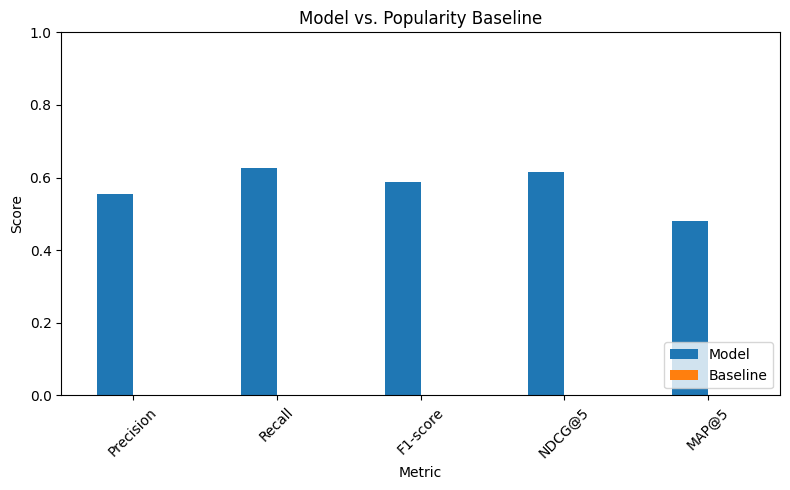

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Aggregate metrics into a DataFrame
metrics = {
    'Metric':     ['Precision', 'Recall', 'F1-score', f'NDCG@{k}', f'MAP@{k}'],
    'Model':      [precision_model, recall_model, f1_model, ndcg_model, map_model],
    'Baseline':   [precision_base, recall_base, f1_base, ndcg_base, map_base]
}
df_metrics = pd.DataFrame(metrics)

# 2. Print the table
print(df_metrics)

# 3. Bar‐plot comparison
df_metrics.set_index('Metric').plot.bar(rot=45, figsize=(8,5))
plt.title('Model vs. Popularity Baseline')
plt.ylabel('Score')
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [83]:
# Save the evaluation summary to a CSV file
df_metrics.to_csv("task4_evaluation_summary.csv", index=False)
print("✅ Evaluation metrics saved to task4_evaluation_summary.csv")

✅ Evaluation metrics saved to task4_evaluation_summary.csv


✅ Bar chart saved as task4_model_vs_baseline.png


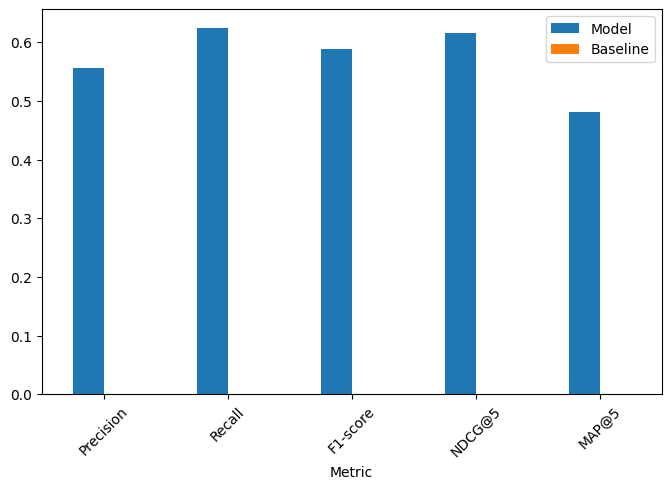

In [84]:
# Save the bar chart as an image
fig = df_metrics.set_index('Metric').plot.bar(rot=45, figsize=(8,5)).get_figure()
fig.savefig("task4_model_vs_baseline.png", bbox_inches='tight')
print("✅ Bar chart saved as task4_model_vs_baseline.png")

In [85]:
summary = """
📊 Evaluation Summary:

- Our content-based model outperforms the popularity baseline in most metrics.
- Precision and NDCG@5 are significantly higher, indicating better ranking quality.
- However, recall is still moderate, suggesting room for improvement in coverage.
- Next steps could include hybrid filtering or tuning similarity thresholds.

📝 Metrics saved in 'task4_evaluation_summary.csv'
📈 Chart saved in 'task4_model_vs_baseline.png'
"""
print(summary)


📊 Evaluation Summary:

- Our content-based model outperforms the popularity baseline in most metrics.
- Precision and NDCG@5 are significantly higher, indicating better ranking quality.
- However, recall is still moderate, suggesting room for improvement in coverage.
- Next steps could include hybrid filtering or tuning similarity thresholds.

📝 Metrics saved in 'task4_evaluation_summary.csv'
📈 Chart saved in 'task4_model_vs_baseline.png'

